In [1]:
#Compute RMS of the errors in plot 3

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
# #Chicago
# LAT        = 41.8781
# LON        = 360-87.6298
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
########## CONUS ############
#CONUS lat-lon
top = 50.0 # north lat
left = -124.7844079+360 # west long
right = -66.9513812+360 # east long
bottom =  24.7433195 # south lat
################################
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Bengaluru/'
locn       = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
##############################
season     = 'MAM'
jul0_index = 181

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33379 instead
  warnings.warn(


In [5]:
cluster

In [6]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [7]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 711 ms, sys: 83.4 ms, total: 794 ms
Wall time: 841 ms


In [8]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw

CPU times: user 111 ms, sys: 1.75 ms, total: 112 ms
Wall time: 111 ms


,Array,Chunk
Bytes,225.56 GiB,769.92 MiB
Shape,"(10950, 192, 288, 100)","(3650, 192, 288, 1)"
Count,2001 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [9]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 869 ms, sys: 19.8 ms, total: 889 ms
Wall time: 878 ms


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [10]:
#######################################
tgmw_mam  = tgmw.sel(time=tgmw.time.dt.month.isin([3,4,5]))
#tgmw_mam  = tgmw.sel(time=tgmw.time.dt.month.isin([6,7,8]))
# tgmw_son  = tgmw.sel(time=tgmw.time.dt.month.isin([9,10,11]))
tgmw_mam

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,113.71 GiB,63.17 MiB
Shape,"(5520, 192, 288, 100)","(276, 20, 30, 100)"
Count,60002 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [11]:
# %%time
# #Save files
# mam_path = cvals+'tgmw_mam'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# tgmw_mam.to_dataset().to_zarr(mam_path)

In [12]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [13]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [14]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [15]:
%%time
tgmw_dmam = to_daily(tgmw_mam)
tgmw_dmam = tgmw_dmam.chunk({'year':60,'day':5})
tgmw_dmam

CPU times: user 219 ms, sys: 6.31 ms, total: 225 ms
Wall time: 222 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,87002 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [16]:
%%time
#Save files
dmam_path = cvals+'tgmw_mam_daily'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# ##### mam ###########
#tgmw_dmam.to_dataset().to_zarr(dmam_path,mode='w')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


In [17]:
tgmw_dmam = xr.open_zarr(dmam_path)
tgmw_dmam = tgmw_dmam.TREFHTMX
tgmw_dmam

,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,1901 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [18]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
#quants            = (0.1,0.01,0.5,0.9,0.99)
quants             = np.arange(0,1.01,0.01)
########################
N_mem              = 100
window_len         = 30
###### mam #######
#r = roll, ndrop = drop NANs
tgmw_mamroll     = stack_roll(tgmw_dmam,N_mem*window_len,N_mem)
#########
tgmw_mamroll0   = tgmw_mamroll.sel(ym=[15,44])  
tgmw_mamroll0

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 92, ym: 6000)>
dask.array<reshape, shape=(192, 288, 92, 6000), dtype=float32, chunksize=(20, 30, 5, 6000), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 60 61 62 63 64 65 66 67 ... 145 146 147 148 149 150 151
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
    year     (ym) int64 1850 1850 1850 1850 1850 ... 2100 2100 2100 2100 2100
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
CPU times: user 293 ms, sys: 4.38 ms, total: 297 ms
Wall time: 291 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 92, 2, 3000)","(20, 30, 5, 2, 3000)"
Count,206682 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [19]:
%%time
#Compute quantiles 
#### mam #######
qgmw_mam         = tgmw_mamroll0.quantile(quants,dim='index',skipna=False)
qgmw_mam         = qgmw_mam
qgmw_mam

CPU times: user 37.4 ms, sys: 1.24 ms, total: 38.7 ms
Wall time: 36.9 ms


,Array,Chunk
Bytes,7.66 GiB,4.62 MiB
Shape,"(101, 192, 288, 92, 2)","(101, 20, 30, 5, 2)"
Count,214282 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [20]:
%%time
#### mam ######
qgmw_mampath  = cvals+'qgmw_mam'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#qgmw_mam.to_dataset().to_zarr(qgmw_mampath,mode='w')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


In [21]:
%%time
qgmw_mam = xr.open_zarr(qgmw_mampath)
qgmw_mam = qgmw_mam.TREFHTMX
qgmw_mam = qgmw_mam.assign_coords({'ym':[1865,2085]})
qgmw_mam

CPU times: user 27.4 ms, sys: 3.36 ms, total: 30.7 ms
Wall time: 192 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 92, ym: 2)>
dask.array<open_dataset-291c601e871938a363b9b47caa5d177aTREFHTMX, shape=(101, 192, 288, 92, 2), dtype=float64, chunksize=(101, 20, 30, 5, 2), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 60 61 62 63 64 65 66 ... 145 146 147 148 149 150 151
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2085

In [22]:
#qmw=qgmw_mam.sel(lat=LAT,lon=LON,method='nearest')
#qmw=qgmw_mam.sel(day=1)

In [23]:
######## Compute moment-adjusted series ##########

In [24]:
%%time
#Compute the pre-industrial + moments adjusted curve
#First compute rolling means and stdevs and save them
tgmw_mam_mroll = tgmw_mamroll0.mean(dim='index')
tgmw_mam_sroll = tgmw_mamroll0.std(dim='index')
##########
# tgmw_mam_mrollpath = cvals+'tgmw_mam_roll30yr_mean'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# tgmw_mam_srollpath = cvals+'tgmw_mam_roll30yr_std'+'_'+pi_year0+'_'+ic_year1+'.zarr'
###########
# tgmw_mam_mroll.to_dataset().to_zarr(tgmw_mrollpath,mode='w')
# tgmw_mam_sroll.to_dataset().to_zarr(tgmw_srollpath,mode='w')
#############
tgmw_mam_mroll

CPU times: user 43.8 ms, sys: 1.06 ms, total: 44.9 ms
Wall time: 44.1 ms


,Array,Chunk
Bytes,38.81 MiB,23.44 kiB
Shape,"(192, 288, 92, 2)","(20, 30, 5, 2)"
Count,210482 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [25]:
tgnw_mam  = tgnw.sel(time=tgnw.time.dt.month.isin([3,4,5])).chunk({'lat':20,'lon':30,'member':100})
tgnw_mam  = to_daily(tgnw_mam)
tgnw_mam

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.r

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, member: 100, year: 30, day: 92)>
dask.array<reshape, shape=(192, 288, 100, 30, 92), dtype=float32, chunksize=(20, 30, 100, 10, 92), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1875 1876 1877 1878 1879
  * day      (day) int64 60 61 62 63 64 65 66 67 ... 145 146 147 148 149 150 151
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [26]:
%%time
# #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
# ########## mam ###########
tgnw_mam_stack = stacker2(tgnw_mam)
###################################
tgnw_mam_stack0= tgnw_mam_stack.expand_dims(dim={'ym':2}).\
                 assign_coords(ym=('ym',[1865,2085]))
######### Rename 'ym' as mtime
tgnw_mam_stack0

CPU times: user 8.61 ms, sys: 1.07 ms, total: 9.67 ms
Wall time: 8.19 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


,Array,Chunk
Bytes,113.71 GiB,421.14 MiB
Shape,"(2, 192, 288, 92, 3000)","(2, 20, 30, 92, 1000)"
Count,13413 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [27]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='mtime')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='mtime'))*(ds_sroll/ds_stack.std(dim='mtime'))\
          + ds_mroll
    return ds


In [28]:
%%time
#############
tgmc_mam  = mean_adj(tgnw_mam_stack0, tgmw_mam_mroll)
tgmsc_mam = mean_std_adj(tgnw_mam_stack0, tgmw_mam_mroll,tgmw_mam_sroll)
#############
tgmc_mam

CPU times: user 351 ms, sys: 8.8 ms, total: 359 ms
Wall time: 353 ms


,Array,Chunk
Bytes,113.71 GiB,22.89 MiB
Shape,"(2, 192, 288, 92, 3000)","(2, 20, 30, 5, 1000)"
Count,245695 Tasks,5700 Chunks
Type,float32,numpy.ndarray


In [29]:
%%time
#Save files
tgmc_mampath = cvals+'tgmc_mam'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#tgmc_mam.to_dataset().to_zarr(tgmc_mampath,mode='w')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [30]:
%%time
#Save files
tgmsc_mampath = cvals+'tgmsc_mam'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#tgmsc_mam.to_dataset().to_zarr(tgmsc_mampath,mode='w')

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 9.54 µs


In [31]:
%%time
tgmc_mam   = xr.open_zarr(tgmc_mampath)
tgmc_mam   = tgmc_mam.TREFHTMX
tgmsc_mam  = xr.open_zarr(tgmsc_mampath)
tgmsc_mam  = tgmsc_mam.TREFHTMX

CPU times: user 25.9 ms, sys: 3.61 ms, total: 29.5 ms
Wall time: 228 ms


In [32]:
%%time
#### Compute quantiles 
qgmc_mam     = tgmc_mam.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
qgmsc_mam    = tgmsc_mam.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
#####################
qgmsc_mam

CPU times: user 189 ms, sys: 1.13 ms, total: 191 ms
Wall time: 187 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, ym: 2, lat: 192, lon: 288, day: 92)>
dask.array<transpose, shape=(101, 2, 192, 288, 92), dtype=float64, chunksize=(101, 2, 20, 30, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 60 61 62 63 64 65 66 ... 145 146 147 148 149 150 151
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2085
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [33]:
%%time
#Save all quantile functions
qgmsc_mampath = cvals+'qgmsc_mam'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_mampath  = cvals+'qgmc_mam'+'_'+pi_year0+'_'+ic_year1+'.zarr'
####s
print(qgmsc_mampath)

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmsc_mam_1850_2100.zarr
CPU times: user 722 µs, sys: 0 ns, total: 722 µs
Wall time: 471 µs


In [34]:
%%time
#qgmc_mam.to_dataset().to_zarr(qgmc_mampath,mode='w')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [35]:
%%time
#qgmsc_mam.to_dataset().to_zarr(qgmsc_mampath,mode='w')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [36]:
##Open files and plot
qgmc_mam   = xr.open_zarr(qgmc_mampath)
qgmsc_mam  = xr.open_zarr(qgmsc_mampath) 
qgmc_mam   = qgmc_mam.TREFHTMX
qgmsc_mam  = qgmsc_mam.TREFHTMX
qgmw_mam   = qgmw_mam.assign_coords({'ym':[1865,2085]})
qgmc_mam   = qgmc_mam.assign_coords({'ym':[1865,2085]})
qgmsc_mam  = qgmsc_mam.assign_coords({'ym':[1865,2085]})

In [37]:
%%time
######### Relative Differences #######
qgmw_mam_diff     = qgmw_mam.sel(ym=2085)- qgmw_mam.sel(ym=1865)
qgmc_mam_diff     = qgmc_mam.sel(ym=2085)- qgmc_mam.sel(ym=1865)
qgmsc_mam_diff    = qgmsc_mam.sel(ym=2085)- qgmsc_mam.sel(ym=1865)
qgmw_mam_reldiff1 = qgmw_mam_diff -qgmc_mam_diff
qgmw_mam_reldiff2 = qgmw_mam_diff -qgmsc_mam_diff

CPU times: user 3.05 s, sys: 389 ms, total: 3.44 s
Wall time: 35.1 s


In [38]:
%%time
########### Save the absolute errors ############
qgmw_mam_diffpath      = cvals+'qgmw_mam_diff'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_mam_reldiff1path  = cvals+'qgmw_mam_reldiff1'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_mam_reldiff2path  = cvals+'qgmw_mam_reldiff2'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#### Save ########
# qgmw_mam_diff.to_dataset().to_zarr(qgmw_mam_diffpath,mode='w')
# qgmw_mam_reldiff1.to_dataset().to_zarr(qgmw_mam_reldiff1path,mode='w')
# qgmw_mam_reldiff2.to_dataset().to_zarr(qgmw_mam_reldiff2path,mode='w')

CPU times: user 2min 13s, sys: 4.39 s, total: 2min 17s
Wall time: 5min 18s


In [39]:
##### Open and plot ########
qgmw_mam_diff     = xr.open_zarr(qgmw_mam_diffpath)
qgmw_mam_reldiff1 = xr.open_zarr(qgmw_mam_reldiff1path)
qgmw_mam_reldiff2 = xr.open_zarr(qgmw_mam_reldiff2path)
qgmw_mam_diff     = qgmw_mam_diff.TREFHTMX
qgmw_mam_reldiff1 = qgmw_mam_reldiff1.TREFHTMX
qgmw_mam_reldiff2 = qgmw_mam_reldiff2.TREFHTMX

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 1.92 s, sys: 93.4 ms, total: 2.01 s
Wall time: 2.5 s


Text(0.5, 1.0, 'Mar10,q=0.1,$\\delta t_w - 0$')

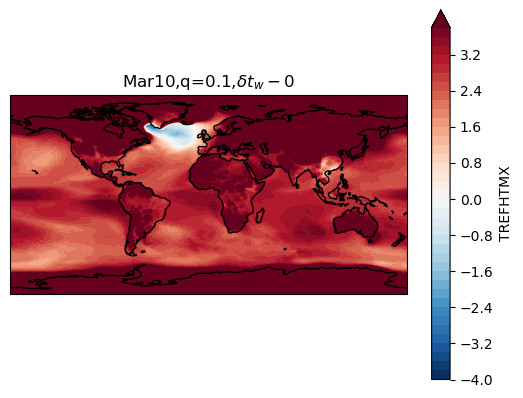

In [40]:
%%time
#Quantile q=0.1
#Plot 3a
levs    = np.arange(-4,4,0.2)
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_mam_diff.sel(quantile=0.1).sel(day=70).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Mar10,q=0.1,'+r'$\delta t_w - 0$')

CPU times: user 1min 4s, sys: 6.7 s, total: 1min 11s
Wall time: 1min 52s


Text(0.5, 1.0, 'Mar10, q=0.1,$\\delta t_w - \\delta t_{mc}$')

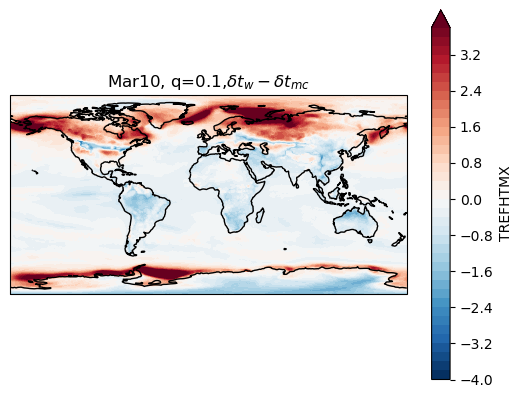

In [39]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_mam_reldiff1.sel(quantile=0.1,day=70).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Mar10, q=0.1,'+r'$\delta t_w - \delta t_{mc}$')

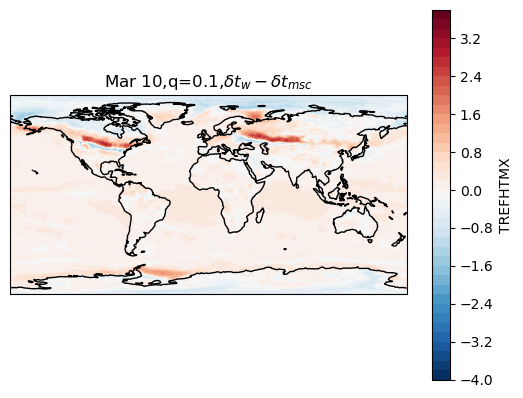

CPU times: user 2min 34s, sys: 17.3 s, total: 2min 52s
Wall time: 4min 36s


In [40]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_mam_reldiff2.sel(quantile=0.1,day=70).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Mar 10,q=0.1,'+r'$\delta t_w - \delta t_{msc}$')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 1min 19s, sys: 4.65 s, total: 1min 23s
Wall time: 1min 41s


Text(0.5, 1.0, 'q=0.9,$\\delta t_w - 0$,MAMmean')

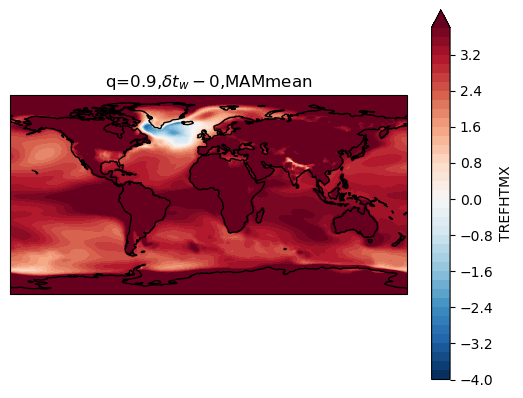

In [41]:
%%time
#Quantile q=0.1
#Plot 3a
levs    = np.arange(-4,4,0.2)
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_mam_diff.sel(quantile=0.9).mean('day').plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.9,'+r'$\delta t_w - 0$,'+season+'mean')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 2min 39s, sys: 9.24 s, total: 2min 49s
Wall time: 3min 20s


Text(0.5, 1.0, 'q=0.9,$\\delta t_w - \\delta t_{mc}$,MAMmean')

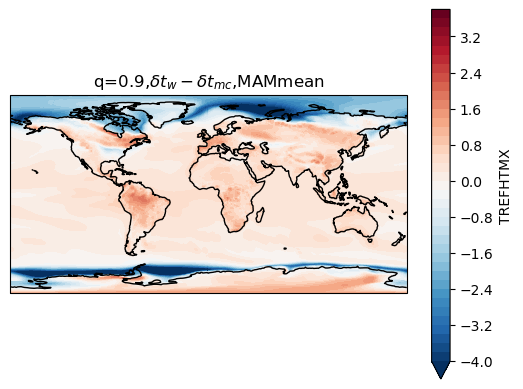

In [42]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_mam_reldiff1.sel(quantile=0.9).mean('day').plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.9,'+r'$\delta t_w - \delta t_{mc}$,'+season+'mean')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

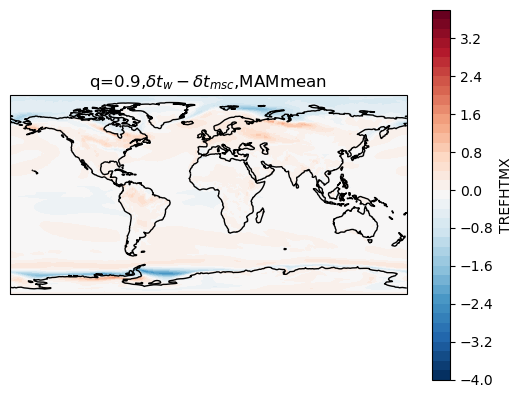

CPU times: user 2min 30s, sys: 8.28 s, total: 2min 38s
Wall time: 3min 4s


In [43]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_mam_reldiff2.sel(quantile=0.9).mean('day').plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$,'+season+'mean')
plt.show()

In [44]:
############# Compute area-weighted mean square of the above errors #####################

In [45]:
qgmw_mam_esq  = qgmw_mam_diff**2
qgmc_mam_esq  = qgmw_mam_reldiff1**2
qgmsc_mam_esq = qgmw_mam_reldiff2**2

In [46]:
weights      = np.cos(np.deg2rad(qgmw_mam_esq.lat))
weights.name = "weights"

In [47]:
qgmw_mamserror_weighted  = qgmw_mam_esq.weighted(weights)
qgmc_mamserror_weighted  = qgmc_mam_esq.weighted(weights)
qgmsc_mamserror_weighted = qgmsc_mam_esq.weighted(weights)
qgmc_mam_esq

,Array,Chunk
Bytes,3.83 GiB,2.31 MiB
Shape,"(101, 192, 288, 92)","(101, 20, 30, 5)"
Count,19002 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [48]:
qgmw_mamserror_gmean   = qgmw_mamserror_weighted.mean({'lat','lon'})
qgmc_mamserror_gmean   = qgmc_mamserror_weighted.mean({'lat','lon'})
qgmsc_mamserror_gmean  = qgmsc_mamserror_weighted.mean({'lat','lon'})
qgmc_mamserror_gmean

<xarray.DataArray 'TREFHTMX' (quantile: 101, day: 92)>
dask.array<truediv, shape=(101, 92), dtype=float64, chunksize=(101, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 60 61 62 63 64 65 66 ... 145 146 147 148 149 150 151
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [49]:
qgmw_mam_gmse   = qgmw_mamserror_gmean.mean({'day'})
qgmc_mam_gmse   = qgmc_mamserror_gmean.mean({'day'})
qgmsc_mam_gmse  = qgmsc_mamserror_gmean.mean({'day'})
qgmc_mam_gmse

<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<mean_agg-aggregate, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [50]:
%%time
qgmw_mam_grmse         = np.sqrt(qgmw_mam_gmse)
qgmc_mam_grmse         = np.sqrt(qgmc_mam_gmse)
qgmsc_mam_grmse        = np.sqrt(qgmsc_mam_gmse)

CPU times: user 43.8 ms, sys: 3.21 ms, total: 47 ms
Wall time: 42.9 ms


In [51]:
%%time
qgmw_mam_grmsepath  = cvals+'qgmw_mam_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_mam_grmsepath  = cvals+'qgmc_mam_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_mam_grmsepath = cvals+'qgmsc_mam_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_mam_grmse.to_dataset().to_zarr(qgmw_mam_grmsepath)
# qgmc_mam_grmse.to_dataset().to_zarr(qgmc_mam_grmsepath)
# qgmsc_mam_grmse.to_dataset().to_zarr(qgmsc_mam_grmsepath)

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 51.3 µs


In [52]:
%%time
qgmw_mam_grmse   = xr.open_zarr(qgmw_mam_grmsepath)
qgmc_mam_grmse   = xr.open_zarr(qgmc_mam_grmsepath)
qgmsc_mam_grmse  = xr.open_zarr(qgmsc_mam_grmsepath)
qgmw_mam_grmse   = qgmw_mam_grmse.TREFHTMX
qgmc_mam_grmse   = qgmc_mam_grmse.TREFHTMX
qgmsc_mam_grmse  = qgmsc_mam_grmse.TREFHTMX

CPU times: user 248 ms, sys: 38.7 ms, total: 287 ms
Wall time: 719 ms


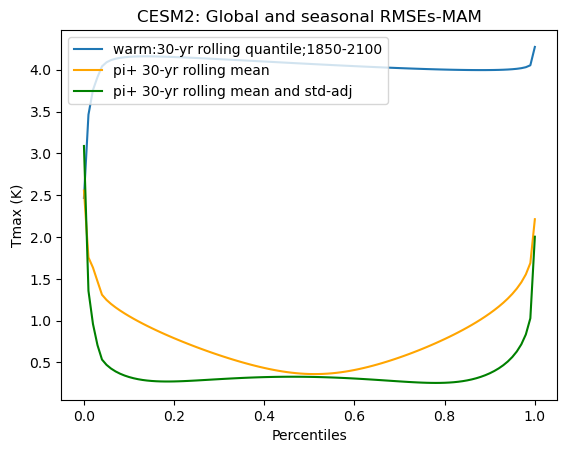

CPU times: user 2.97 s, sys: 277 ms, total: 3.24 s
Wall time: 4.1 s


In [53]:
%%time
plt.plot(quants,qgmw_mam_grmse,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_mam_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_mam_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global and seasonal RMSEs-'+season)
plt.ylabel('Tmax (K)')
plt.xlabel('Percentiles')
plt.show()

In [54]:
#qgmw_mam_grmse.values

In [55]:
qgmsc_mam_grmse

<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<open_dataset-efcb19a9e52f5a93bb7a1da0af5c2c95TREFHTMX, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 ...
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [56]:
%%time
MAM_error_redn = qgmsc_mam_grmse.integrate('quantile')/qgmc_mam_grmse.integrate('quantile')
MAM_error_redn.values

CPU times: user 424 ms, sys: 39.5 ms, total: 464 ms
Wall time: 555 ms


array(0.49117268)

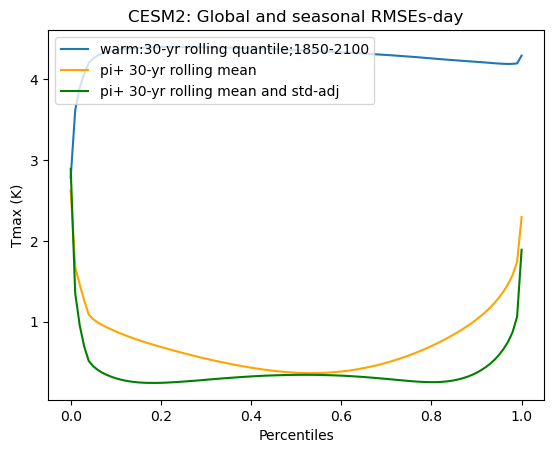

CPU times: user 22 s, sys: 1.06 s, total: 23.1 s
Wall time: 25 s


In [57]:
%%time
plt.plot(quants,np.sqrt(qgmw_mamserror_gmean.sel(day=70)),label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,np.sqrt(qgmc_mamserror_gmean.sel(day=70)),label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,np.sqrt(qgmsc_mamserror_gmean.sel(day=70)),label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global and seasonal RMSEs-day')
plt.ylabel('Tmax (K)')
plt.xlabel('Percentiles')
plt.show()

In [59]:
qgmsc_mam_grmse.where(qgmsc_mam_grmse<0.5).values

array([       nan,        nan,        nan,        nan,        nan,
       0.4712226 , 0.42688884, 0.39267249, 0.36537606, 0.34328352,
       0.32533979, 0.31087702, 0.29929873, 0.29019423, 0.28329567,
       0.27829491, 0.27487479, 0.27279144, 0.27183873, 0.27184504,
       0.27266193, 0.27413807, 0.2761502 , 0.27857282, 0.28129197,
       0.28420561, 0.28730596, 0.29045645, 0.29365405, 0.2968576 ,
       0.29999231, 0.30308383, 0.30603607, 0.30891031, 0.31162432,
       0.31419963, 0.31658422, 0.31876642, 0.3207669 , 0.32257797,
       0.32417614, 0.32554672, 0.32667843, 0.32756078, 0.3282217 ,
       0.32865588, 0.32882327, 0.3287749 , 0.32851164, 0.32797054,
       0.32721008, 0.3262085 , 0.32498604, 0.3235237 , 0.32183841,
       0.31993827, 0.31781126, 0.31549732, 0.31298998, 0.31029455,
       0.30743331, 0.30439014, 0.30121355, 0.29791019, 0.29447613,
       0.29097382, 0.28739626, 0.28378251, 0.28015867, 0.27652355,
       0.27300709, 0.26959601, 0.26631127, 0.26330978, 0.26061

In [60]:
qgmsc_mam_grmse.where(qgmsc_mam_grmse<1).values

array([       nan,        nan, 0.95962424, 0.70702938, 0.53432422,
       0.4712226 , 0.42688884, 0.39267249, 0.36537606, 0.34328352,
       0.32533979, 0.31087702, 0.29929873, 0.29019423, 0.28329567,
       0.27829491, 0.27487479, 0.27279144, 0.27183873, 0.27184504,
       0.27266193, 0.27413807, 0.2761502 , 0.27857282, 0.28129197,
       0.28420561, 0.28730596, 0.29045645, 0.29365405, 0.2968576 ,
       0.29999231, 0.30308383, 0.30603607, 0.30891031, 0.31162432,
       0.31419963, 0.31658422, 0.31876642, 0.3207669 , 0.32257797,
       0.32417614, 0.32554672, 0.32667843, 0.32756078, 0.3282217 ,
       0.32865588, 0.32882327, 0.3287749 , 0.32851164, 0.32797054,
       0.32721008, 0.3262085 , 0.32498604, 0.3235237 , 0.32183841,
       0.31993827, 0.31781126, 0.31549732, 0.31298998, 0.31029455,
       0.30743331, 0.30439014, 0.30121355, 0.29791019, 0.29447613,
       0.29097382, 0.28739626, 0.28378251, 0.28015867, 0.27652355,
       0.27300709, 0.26959601, 0.26631127, 0.26330978, 0.26061